In [2]:
import os
import networkx as nx
import pandas as pd
import geopandas as gpd
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from tqdm import tqdm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
data_dir = "../data"
os.listdir(data_dir)

['bus_stops_wszone.dbf',
 'bus_stops_wszone.shp',
 'singstat',
 'net_202001_15.net',
 'OD_bus',
 'net_202001_05.net',
 'net_202001_06.net',
 'origin_destination_train_201912.csv.xz',
 'train_station_wszone.prj',
 'origin_destination_train_202001.csv.xz',
 'train_station_wszone.dbf',
 'OD_202001_weekend.csv.xz',
 'net_202001_22.net',
 'subzone_centroid.csv',
 'OD_201912_weekday.csv.xz',
 'origin_destination_bus_201911.csv.xz',
 'net_202001_19.net',
 'net_202001_18.net',
 'train_station_wszone.cpg',
 'OD_PT',
 'train_station_wszone.shx',
 'net_202001_10.net',
 'OD_201911_weekend.csv.xz',
 'origin_destination_train_201911.csv.xz',
 'planning-area-2014',
 'net_202001_weekend.net',
 'subzone_centroid_pos.json',
 '.ipynb_checkpoints',
 'net_202001_21.net',
 'origin_destination_bus_202001.csv.xz',
 'OD_201912_weekend.csv.xz',
 'net_202001_07.net',
 'origin_destination_bus_201912.csv.xz',
 'net_202001_23.net',
 'region-2014',
 'train_station_wszone.shp',
 'net_202001_weekday.net',
 'net_202001

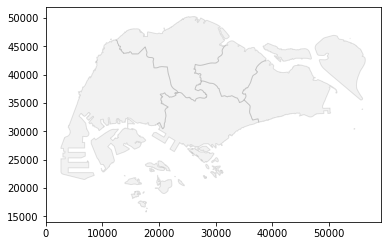

In [5]:
os.listdir("../data")
region = gpd.read_file("../data/region-2014/MP14_REGION_WEB_PL.shp")
region.plot(color="grey", edgecolor="k", alpha=0.1)

In [6]:
with open(os.path.join("../data", 'subzone_centroid_pos.json'), 'r') as fread:
    pos = json.load(fread)
pos["MARINA SOUTH"]

[31595.83574613999, 29220.18737674884]

## Prepare network data

In [7]:
df1 = pd.read_csv(os.path.join(data_dir, 'OD_202001_weekday.csv.xz'))
df1.head()

,ind,origin,destination,hour_05,hour_06,hour_07,hour_08,hour_09,hour_10,hour_11,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,0,TAMPINES EAST,TAMPINES EAST,232925.0,1427066.0,2316704.0,1778107.0,1280905.0,1145098.0,1084878.0,...,1382846.0,1305843.0,1400255.0,1652029.0,2019632.0,1676532.0,1141877.0,984449.0,739684.0,391909.0
1,1,SENOKO NORTH,YISHUN CENTRAL,3560.0,14560.0,7020.0,6380.0,4740.0,4140.0,5820.0,...,10480.0,17540.0,22060.0,46820.0,55680.0,23640.0,16620.0,8300.0,4840.0,1940.0
2,2,FERNVALE,TRAFALGAR,2680.0,25980.0,19620.0,24980.0,14180.0,10240.0,8260.0,...,9060.0,10400.0,11820.0,18520.0,19040.0,12060.0,8360.0,7320.0,6780.0,3160.0
3,3,CHINATOWN,PORT,328.0,3482.0,1452.0,1084.0,1128.0,602.0,534.0,...,866.0,908.0,747.0,886.0,564.0,754.0,702.0,553.0,573.0,496.0
4,4,LAKESIDE,TAMAN JURONG,408.0,6854.0,12863.0,18283.0,7809.0,7015.0,6526.0,...,12956.0,23380.0,13425.0,15333.0,15933.0,8697.0,7677.0,4723.0,3355.0,1720.0


In [8]:
hours_col = [ col for col in df1.columns.tolist() if "hour" in col ]
sum_col = df1[hours_col[0]]
for col in hours_col[1:]:
    sum_col = sum_col + df1[col]
df1["sum_weekday"] = sum_col
df1.head()

,ind,origin,destination,hour_05,hour_06,hour_07,hour_08,hour_09,hour_10,hour_11,...,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,sum_weekday
0,0,TAMPINES EAST,TAMPINES EAST,232925.0,1427066.0,2316704.0,1778107.0,1280905.0,1145098.0,1084878.0,...,1305843.0,1400255.0,1652029.0,2019632.0,1676532.0,1141877.0,984449.0,739684.0,391909.0,24696617.0
1,1,SENOKO NORTH,YISHUN CENTRAL,3560.0,14560.0,7020.0,6380.0,4740.0,4140.0,5820.0,...,17540.0,22060.0,46820.0,55680.0,23640.0,16620.0,8300.0,4840.0,1940.0,272160.0
2,2,FERNVALE,TRAFALGAR,2680.0,25980.0,19620.0,24980.0,14180.0,10240.0,8260.0,...,10400.0,11820.0,18520.0,19040.0,12060.0,8360.0,7320.0,6780.0,3160.0,233880.0
3,3,CHINATOWN,PORT,328.0,3482.0,1452.0,1084.0,1128.0,602.0,534.0,...,908.0,747.0,886.0,564.0,754.0,702.0,553.0,573.0,496.0,18463.0
4,4,LAKESIDE,TAMAN JURONG,408.0,6854.0,12863.0,18283.0,7809.0,7015.0,6526.0,...,23380.0,13425.0,15333.0,15933.0,8697.0,7677.0,4723.0,3355.0,1720.0,182523.0


In [9]:
df2 = pd.read_csv(os.path.join(data_dir, 'OD_202001_weekend.csv.xz'))
hours_col = [ col for col in df2.columns.tolist() if "hour" in col ]
sum_col = df2[hours_col[0]]
for col in hours_col[1:]:
    sum_col = sum_col + df2[col]
df2["sum_weekend"] = sum_col
df2.head()

,ind,origin,destination,hour_05,hour_06,hour_07,hour_08,hour_09,hour_10,hour_11,...,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,sum_weekend
0,0,TAMPINES EAST,TAMPINES EAST,48619.0,158327.0,277360.0,411257.0,508498.0,573099.0,605327.0,...,555808.0,568718.0,616855.0,578631.0,522250.0,454249.0,418694.0,328079.0,188590.0,8609081.0
1,1,BRADDELL,TOWNSVILLE,360.0,560.0,460.0,900.0,1260.0,1220.0,1360.0,...,1000.0,1300.0,780.0,1120.0,720.0,700.0,720.0,620.0,400.0,16740.0
2,2,DEFU INDUSTRIAL PARK,GEYLANG EAST,260.0,1000.0,2900.0,4220.0,4420.0,4220.0,5380.0,...,2820.0,2260.0,2600.0,2400.0,1500.0,580.0,520.0,200.0,80.0,44880.0
3,3,TRAFALGAR,TRAFALGAR,3842.0,13508.0,18882.0,30368.0,39670.0,43908.0,45014.0,...,40494.0,39684.0,42442.0,41718.0,43242.0,33512.0,29664.0,24186.0,11780.0,640296.0
4,4,GEYLANG EAST,PEARL'S HILL,140.0,360.0,300.0,560.0,1060.0,820.0,1020.0,...,820.0,640.0,600.0,760.0,1000.0,900.0,440.0,560.0,460.0,14080.0


In [10]:
df1b = df1.dropna(subset=["origin", "destination"])
df2b = df2.dropna(subset=["origin", "destination"])

In [11]:
df_merge = pd.merge(df1b[["origin", "destination", "sum_weekday"]], df2b[["origin", "destination", "sum_weekend"]], left_on=["origin", "destination"], right_on=["origin", "destination"], )
df_merge.head()

,origin,destination,sum_weekday,sum_weekend
0,TAMPINES EAST,TAMPINES EAST,24696617.0,8609081.0
1,SENOKO NORTH,YISHUN CENTRAL,272160.0,82380.0
2,FERNVALE,TRAFALGAR,233880.0,92980.0
3,CHINATOWN,PORT,18463.0,5805.0
4,LAKESIDE,TAMAN JURONG,182523.0,65905.0


In [12]:
df_merge2 = df_merge.copy()
df_merge2["sum_weekday"] = df_merge2["sum_weekday"]/23
df_merge2["sum_weekend"] = df_merge2["sum_weekend"]/8
df_merge2[["sum_weekday", "sum_weekend"]].sum()

sum_weekday    7.630640e+07
sum_weekend    7.607030e+07
dtype: float64

In [13]:
len(df_merge2)

30331

## prepare the data and run code

In [11]:
for col in ["sum_weekday", "sum_weekend"]:
    dg1 = nx.DiGraph()
    for s,t,f in zip(df_merge["origin"], df_merge["destination"], df_merge2[col]):
        if s==t: continue
        if f<=0: continue
        """    
        if col=="sum_weekday":
            f = f/23
        else:
            f = f/8
        """
        dg1.add_edge(s,t,weight=f)
    print(col[4:], dg1.number_of_edges())
    nx.write_pajek(dg1, os.path.join(data_dir, "net_202001_{}b.net".format(col[4:])))

weekday 30043
weekend 30043


In [14]:
30331-30043

288

## convert mapequation result to csv

In [12]:
fs = os.listdir(os.path.join("../", "mapequation"))
fs = sorted([ f for f in fs if ".tree" in f ])
fs = ['net_202001_weekday.tree', 'net_202001_weekend.tree']

In [13]:
for f in fs:
    print(f)
    res_fp = os.path.join("../", "mapequation", f)
    df_res = pd.read_csv(res_fp, sep=" ", header=None, skiprows=2, names=["clusters", "flow", "node", "ori_index"])
    layers = []
    for c in df_res["clusters"]:
        cs = c.split(":")
        lvl = 1
        la_str = ""
        this_layers = {}
        for la in cs:
            if len(la_str)==0:
                la_str = la
            else:
                la_str = la_str+"_"+la
            this_layers["level_{}".format(lvl)] = la_str
            lvl+=1
        layers.append(this_layers)
    df_lvl = pd.DataFrame.from_dict(layers)
    df_res = df_res.merge(df_lvl, left_index=True, right_index=True)
    #df_res.head()
    df_res.to_csv(os.path.join("../", "mapequation", f.replace(".tree", ".csv")), index_label="ind")

net_202001_weekday.tree
net_202001_weekend.tree


## prepare color

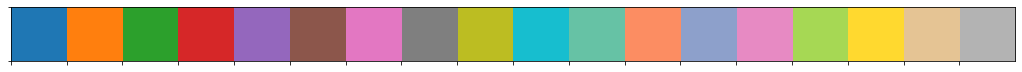

In [14]:
current_palette = sns.color_palette() + sns.color_palette("Set2")
#current_palette = sns.color_palette("Set2")#, 14)
sns.palplot(current_palette)

## Draw result for weekday

In [15]:
f = "net_202001_weekday.csv"
df_res = pd.read_csv(os.path.join("../", "mapequation", f), index_col=0)
df_res.head()

,clusters,flow,node,ori_index,level_1,level_2
ind,,,,,,
0,1:1,0.023149,TAMPINES EAST,40,1,1_1
1,1:2,0.017636,BEDOK NORTH,16,1,1_2
2,1:3,0.013683,TOA PAYOH CENTRAL,68,1,1_3
3,1:4,0.013282,ALJUNIED,21,1,1_4
4,1:5,0.012734,TAMPINES WEST,78,1,1_5


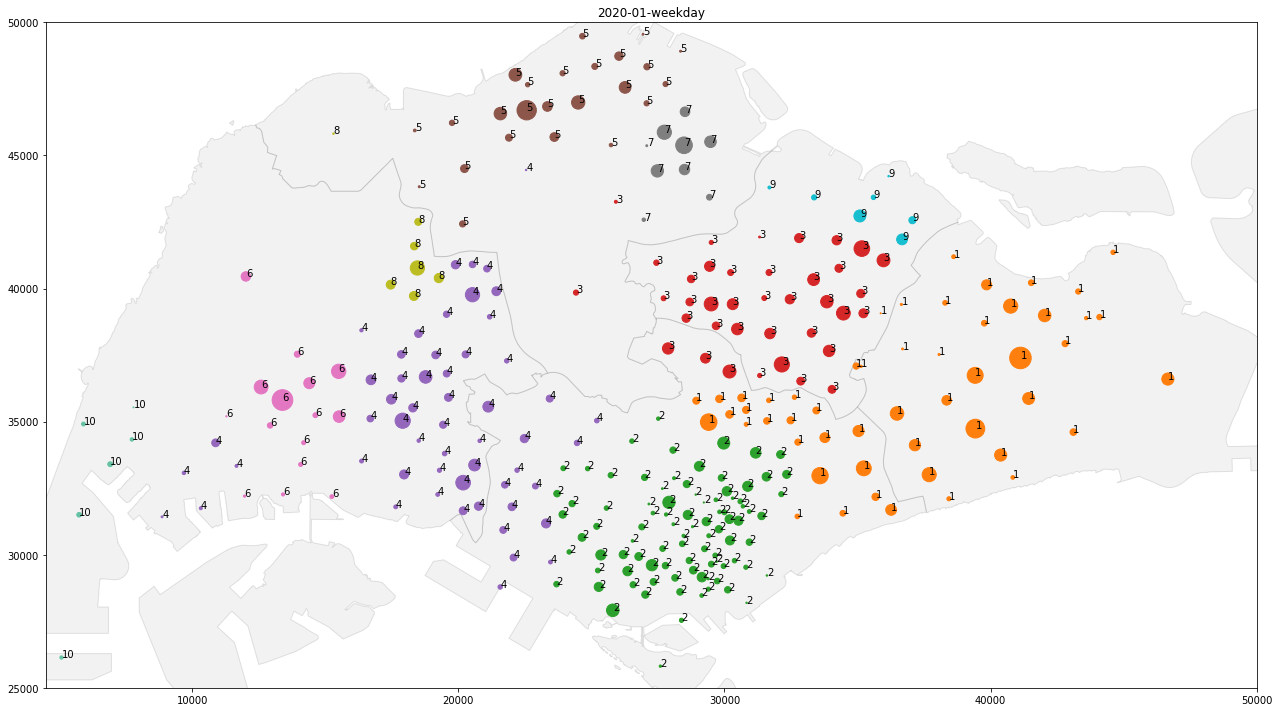

In [16]:
xs = []
ys = []
cs = []
fs = []
ws = []

for i in range(len(df_res)):
    row = df_res.iloc[i]
    node = row["node"]
    if pd.isnull(row["node"]):
        print(row)
    layer = int(row["level_1"])
    flow = row["flow"]
    x,y = pos[node]
    clr = current_palette[layer] if layer<len(current_palette) else "grey"
    xs.append(x)
    ys.append(y)
    cs.append(clr)
    fs.append(flow*20000)
    ws.append(layer)
    #break
fig, ax = plt.subplots(figsize=(20,10))
ax.set_aspect("equal")
region.plot(ax=ax, color="grey", edgecolor="k", alpha=0.1)
ax.set_xlim([4500,50000])
ax.set_ylim([25000,50000])
ax.scatter(xs, ys, s=fs, color=cs)

for i, txt in enumerate(ws):
    ax.annotate(txt, (xs[i], ys[i]))
ax.set_title("2020-01-weekday")
plt.tight_layout()
plt.savefig("2020-01-weekday-community.png", dpi=100, bbox_inches="tight")

## draw result for weekend

In [17]:
f2 = "net_202001_weekend.csv"
df_res2 = pd.read_csv(os.path.join("../", "mapequation", f2), index_col=0)
df_res2.head()

,clusters,flow,node,ori_index,level_1,level_2
ind,,,,,,
0,1:1,0.015337,ALJUNIED,21,1,1_1
1,1:2,0.013425,GEYLANG EAST,10,1,1_2
2,1:3,0.010406,BOULEVARD,79,1,1_3
3,1:4,0.009332,MARITIME SQUARE,38,1,1_4
4,1:5,0.007980,BALESTIER,108,1,1_5


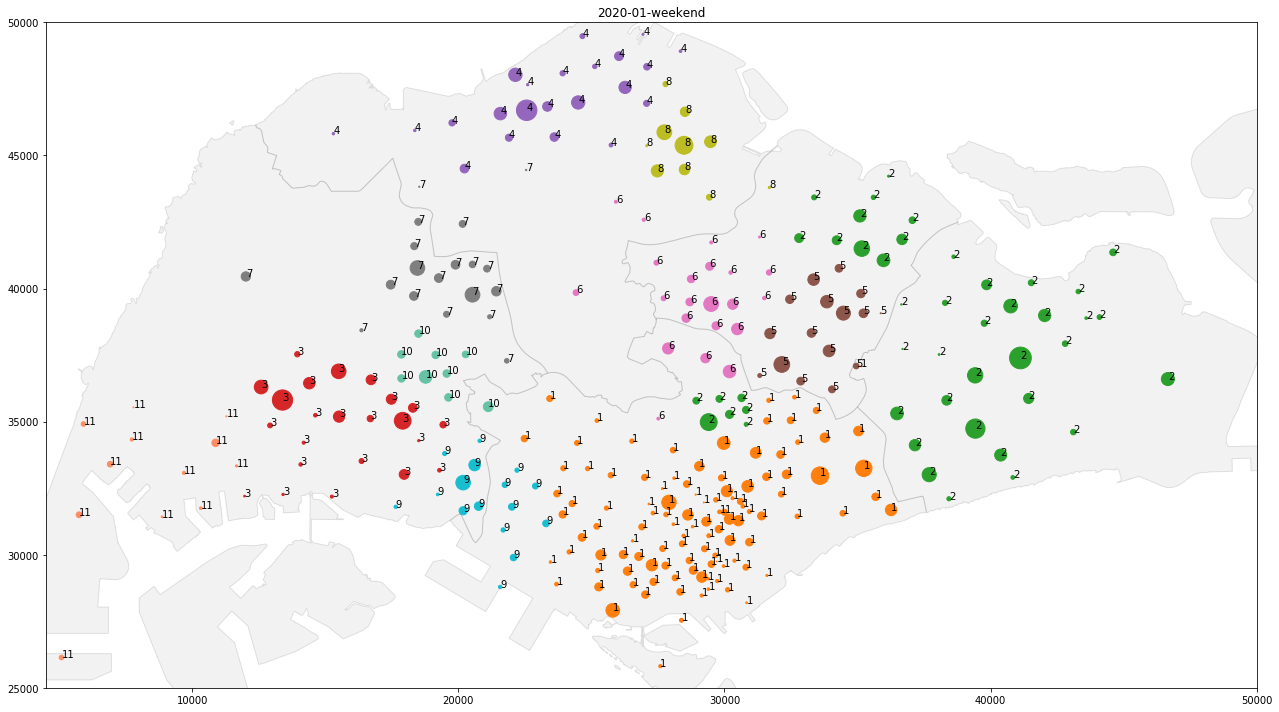

In [18]:
xs = []
ys = []
cs = []
fs = []
ws = []

for i in range(len(df_res2)):
    row = df_res2.iloc[i]
    node = row["node"]
    if pd.isnull(row["node"]):
        print(row)
    layer = int(row["level_1"])
    flow = row["flow"]
    x,y = pos[node]
    clr = current_palette[layer] if layer<len(current_palette) else "grey"
    xs.append(x)
    ys.append(y)
    cs.append(clr)
    fs.append(flow*20000)
    ws.append(layer)
    #break
fig, ax = plt.subplots(figsize=(20,10))
ax.set_aspect("equal")
region.plot(ax=ax, color="grey", edgecolor="k", alpha=0.1)
ax.set_xlim([4500,50000])
ax.set_ylim([25000,50000])
ax.scatter(xs, ys, s=fs, color=cs)

for i, txt in enumerate(ws):
    ax.annotate(txt, (xs[i], ys[i]))
ax.set_title("2020-01-weekend")
plt.tight_layout()
plt.savefig("2020-01-weekend-community.png", dpi=100, bbox_inches="tight")

## draw community on polygon map

In [19]:
subzone_fp = os.path.join(data_dir, "subzone-2014", "MP14_SUBZONE_WEB_PL.shp")
subzone = gpd.read_file(subzone_fp)
subzone.head()

,OBJECTID,SUBZONE_NO,SUBZONE_N,SUBZONE_C,CA_IND,PLN_AREA_N,PLN_AREA_C,REGION_N,REGION_C,INC_CRC,FMEL_UPD_D,X_ADDR,Y_ADDR,SHAPE_Leng,SHAPE_Area,geometry
0,1,1,MARINA SOUTH,MSSZ01,Y,MARINA SOUTH,MS,CENTRAL REGION,CR,5ED7EB253F99252E,2014-12-05,31595.8357,29220.1873,5267.381024,1.630379e+06,"POLYGON ((31495.560 30140.012, 31980.957 29671..."
1,2,1,PEARL'S HILL,OTSZ01,Y,OUTRAM,OT,CENTRAL REGION,CR,8C7149B9EB32EEFC,2014-12-05,28679.0634,29782.0519,3506.107376,5.598162e+05,"POLYGON ((29092.275 30021.888, 29119.641 30006..."
2,3,3,BOAT QUAY,SRSZ03,Y,SINGAPORE RIVER,SR,CENTRAL REGION,CR,C35FEFF02B13E0E5,2014-12-05,29654.9594,29974.6553,1740.925766,1.608075e+05,"POLYGON ((29932.332 29879.120, 29947.317 29858..."
3,4,8,HENDERSON HILL,BMSZ08,N,BUKIT MERAH,BM,CENTRAL REGION,CR,3775D82C5DDBEFBD,2014-12-05,26782.8261,29933.7651,3313.624904,5.954289e+05,"POLYGON ((27131.276 30059.727, 27088.334 29709..."
4,5,3,REDHILL,BMSZ03,N,BUKIT MERAH,BM,CENTRAL REGION,CR,85D9ABEF0A40678F,2014-12-05,26201.9580,30005.7035,2825.594099,3.874294e+05,"POLYGON ((26451.027 30396.458, 26440.474 30361..."


In [20]:
df_res.head()

,clusters,flow,node,ori_index,level_1,level_2
ind,,,,,,
0,1:1,0.023149,TAMPINES EAST,40,1,1_1
1,1:2,0.017636,BEDOK NORTH,16,1,1_2
2,1:3,0.013683,TOA PAYOH CENTRAL,68,1,1_3
3,1:4,0.013282,ALJUNIED,21,1,1_4
4,1:5,0.012734,TAMPINES WEST,78,1,1_5


In [22]:
subzone2 = subzone.merge(df_res, left_on="SUBZONE_N", right_on="node", )
len(subzone2), len(subzone)

(303, 323)

In [31]:
subzone2_union = subzone2.dissolve(by='level_1').reset_index()
subzone2_union.head()

,level_1,geometry,OBJECTID,SUBZONE_NO,SUBZONE_N,SUBZONE_C,CA_IND,PLN_AREA_N,PLN_AREA_C,REGION_N,...,FMEL_UPD_D,X_ADDR,Y_ADDR,SHAPE_Leng,SHAPE_Area,clusters,flow,node,ori_index,level_2
0,1,"POLYGON ((31632.977 30741.729, 31561.689 30728...",68,5,TANJONG RHU,KLSZ05,N,KALLANG,KL,CENTRAL REGION,...,2014-12-05,32740.1208,31438.3084,6515.758575,2.434594e+06,1:39,0.001063,TANJONG RHU,54,1_39
1,2,"MULTIPOLYGON (((26066.693 25744.307, 26074.221...",1,1,MARINA SOUTH,MSSZ01,Y,MARINA SOUTH,MS,CENTRAL REGION,...,2014-12-05,31595.8357,29220.1873,5267.381024,1.630379e+06,2:87,0.000110,MARINA SOUTH,300,2_87
2,3,"POLYGON ((34312.336 37001.844, 34295.750 36950...",176,7,UPPER PAYA LEBAR,SGSZ07,N,SERANGOON,SG,NORTH-EAST REGION,...,2014-12-05,32866.5229,36522.0741,4658.999428,8.985613e+05,3:24,0.003077,UPPER PAYA LEBAR,201,3_24
3,4,"MULTIPOLYGON (((11059.896 32548.121, 11106.830...",9,13,PASIR PANJANG 1,QTSZ13,N,QUEENSTOWN,QT,CENTRAL REGION,...,2014-12-05,22077.3383,29893.7812,6571.323082,1.084792e+06,4:28,0.002374,PASIR PANJANG 1,204,4_28
4,5,"POLYGON ((21410.158 41655.277, 21448.724 41356...",257,1,KRANJI,SKSZ01,N,SUNGEI KADUT,SK,NORTH REGION,...,2014-12-05,19766.8432,46226.3545,7899.952343,3.652031e+06,5:15,0.001425,KRANJI,207,5_15


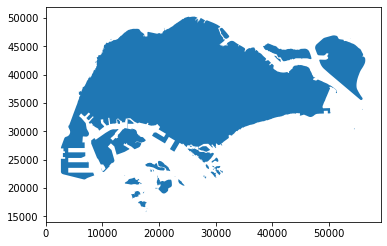

In [72]:
union_geom = gpd.GeoSeries(region.geometry.unary_union)
union_geom.plot()

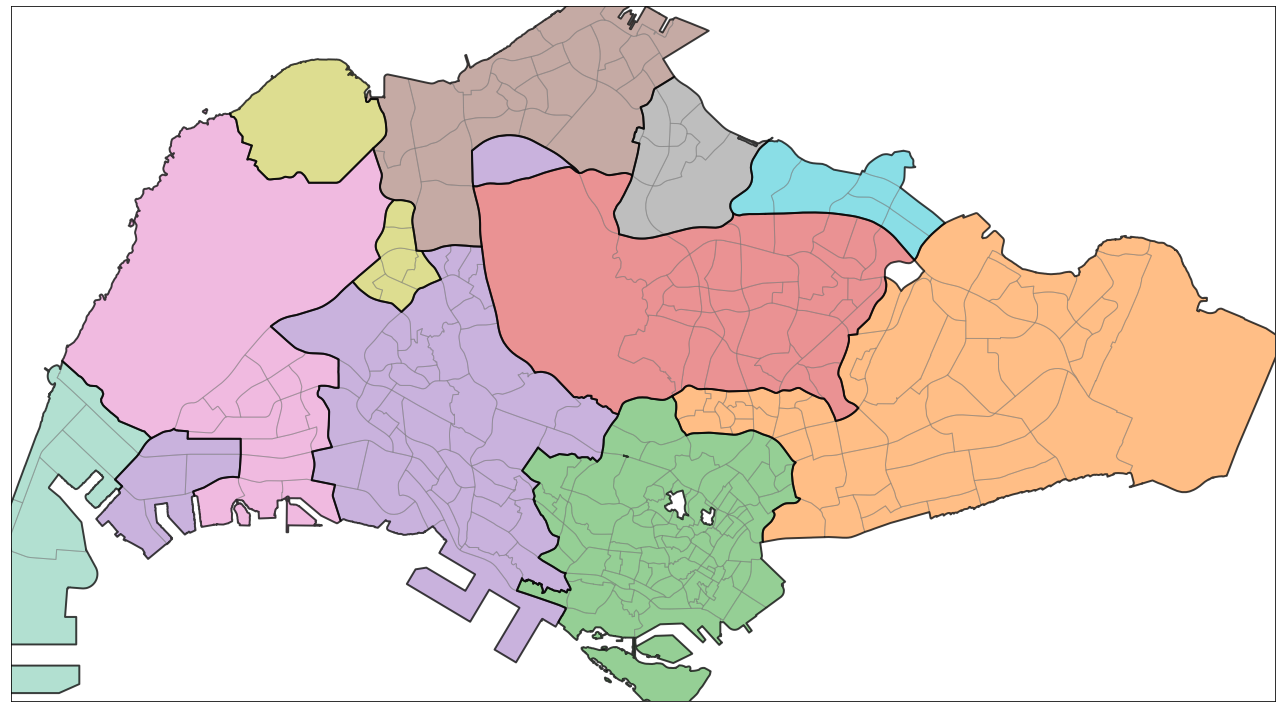

In [51]:
fig, ax = plt.subplots(1,1, figsize=(20,10))

newcmp = ListedColormap(current_palette)
#subzone2.plot(column="level_1", ec="gray", lw=1., ax=ax, cmap=newcmp, alpha=.5, legend=True)
for i in sorted(set(subzone2["level_1"].tolist())):
    temp = subzone2[subzone2["level_1"]==i]
    temp.plot(fc=current_palette[i], ec="gray", lw=1., ax=ax, alpha=.5)
subzone2_union.plot(fc="none", ec="k", lw=2., ax=ax, alpha=.7)
ax.set_xlim([4500,50000])
ax.set_ylim([25000,50000])
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()

In [45]:
subzone3 = subzone.merge(df_res2, left_on="SUBZONE_N", right_on="node", )
print(len(subzone3), len(subzone))
subzone3_union = subzone3.dissolve(by='level_1').reset_index()
subzone3_union.head()

303 323


,level_1,geometry,OBJECTID,SUBZONE_NO,SUBZONE_N,SUBZONE_C,CA_IND,PLN_AREA_N,PLN_AREA_C,REGION_N,...,FMEL_UPD_D,X_ADDR,Y_ADDR,SHAPE_Leng,SHAPE_Area,clusters,flow,node,ori_index,level_2
0,1,"MULTIPOLYGON (((26066.693 25744.307, 26074.221...",1,1,MARINA SOUTH,MSSZ01,Y,MARINA SOUTH,MS,CENTRAL REGION,...,2014-12-05,31595.8357,29220.1873,5267.381024,1.630379e+06,1:102,0.000217,MARINA SOUTH,300,1_102
1,2,"MULTIPOLYGON (((31229.748 34805.445, 31231.154...",77,7,SIGLAP,BDSZ07,N,BEDOK,BD,EAST REGION,...,2014-12-05,38435.4679,32101.8812,5436.890533,1.097834e+06,2:37,0.000864,SIGLAP,198,2_37
2,3,"POLYGON ((14483.480 31219.940, 14483.389 31211...",91,5,WEST COAST,CLSZ05,N,CLEMENTI,CL,WEST REGION,...,2014-12-05,19293.7625,33172.6228,3644.131828,7.225887e+05,3:16,0.000673,WEST COAST,14,3_16
3,4,"POLYGON ((21116.195 43822.548, 21118.797 43696...",257,1,KRANJI,SKSZ01,N,SUNGEI KADUT,SK,NORTH REGION,...,2014-12-05,19766.8432,46226.3545,7899.952343,3.652031e+06,4:12,0.001995,KRANJI,207,4_12
4,5,"POLYGON ((34995.286 35552.316, 34981.231 35536...",176,7,UPPER PAYA LEBAR,SGSZ07,N,SERANGOON,SG,NORTH-EAST REGION,...,2014-12-05,32866.5229,36522.0741,4658.999428,8.985613e+05,5:11,0.003025,UPPER PAYA LEBAR,201,5_11


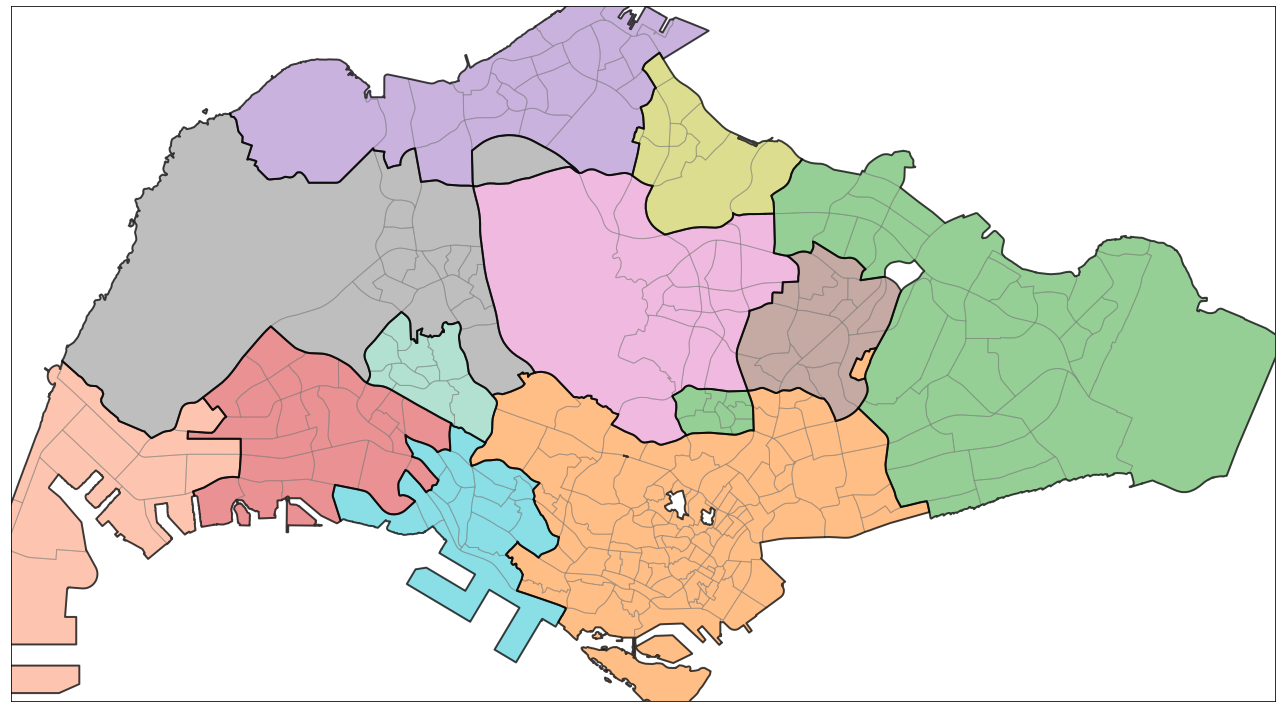

In [52]:
fig, ax = plt.subplots(1,1, figsize=(20,10))

newcmp = ListedColormap(current_palette)
#subzone3.plot(column="level_1", ec="gray", lw=1., ax=ax, cmap=newcmp, alpha=.5, legend=True)
for i in sorted(set(subzone3["level_1"].tolist())):
    temp = subzone3[subzone3["level_1"]==i]
    temp.plot(fc=current_palette[i], ec="gray", lw=1., ax=ax, alpha=.5)
subzone3_union.plot(fc="none", ec="k", lw=2., ax=ax, alpha=.7)
ax.set_xlim([4500,50000])
ax.set_ylim([25000,50000])
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()

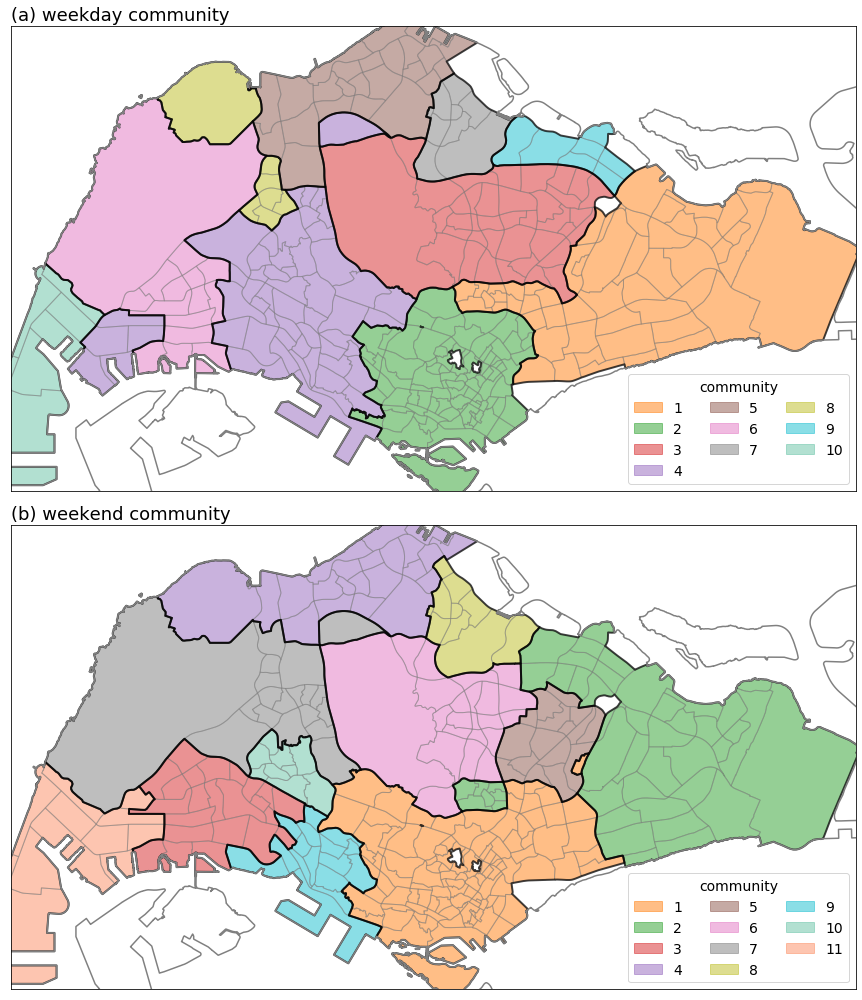

In [73]:
fig, axs = plt.subplots(2,1, figsize=(14,14))

newcmp = ListedColormap(current_palette)

patches1 = []
#subzone2.plot(column="level_1", ec="gray", lw=1., ax=ax, cmap=newcmp, alpha=.5, legend=False)
for i in sorted(set(subzone2["level_1"].tolist())):
    temp = subzone2[subzone2["level_1"]==i]
    temp.plot(fc=current_palette[i], ec="gray", lw=1., ax=axs[0], alpha=.5)
    pat = mpatches.Patch(color=current_palette[i], label=i, alpha=.5)
    patches1.append(pat)
subzone2_union.plot(fc="none", ec="k", lw=2., ax=axs[0], alpha=.7)
leg1 = axs[0].legend(handles=patches1, ncol=3, fontsize=14, loc="lower right")
leg1.set_title("community", prop={'size':14})

patches2 = []
#subzone3.plot(column="level_1", ec="gray", lw=1., ax=axs[1], cmap=newcmp, alpha=.5, legend=False)
for i in sorted(set(subzone3["level_1"].tolist())):
    temp = subzone3[subzone3["level_1"]==i]
    temp.plot(fc=current_palette[i], ec="gray", lw=1., ax=axs[1], alpha=.5)
    pat = mpatches.Patch(color=current_palette[i], label=i, alpha=.5)
    patches2.append(pat)
subzone3_union.plot(fc="none", ec="k", lw=2., ax=axs[1], alpha=.7)
leg2 = axs[1].legend(handles=patches2, ncol=3, fontsize=14, loc="lower right")
leg2.set_title("community", prop={'size':14})


i = 0
labs = "ab"
labs2 = ["weekday community", "weekend community"]
for ax in axs:
    union_geom.plot(fc="none", ec="gray", lw=1.5, ax=ax)
    ax.set_xlim([4500,50000])
    ax.set_ylim([25000,50000])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("({}) {}".format(labs[i], labs2[i]), loc="left", fontsize=18)
    i+=1



plt.tight_layout()
plt.savefig("figs/community_detection_result.png", dpi=100, bbox_inches="tight")

## extra analysis

In [77]:
community = { k:l for k,l in zip(df_res["node"], df_res["level_1"]) }


In [78]:
dg2 = nx.DiGraph()
for u,v,d in dg1_08.edges(data=True):
    if d["weight"]==0: continue
    cu = community[u]
    cv = community[v]
    if dg2.has_edge(cu,cv):
        dg2[cu][cv]["weight"]+=d["weight"]
    else:
        dg2.add_edge(cu, cv, weight=d["weight"])
dg2.number_of_nodes(), dg2.number_of_edges()

(13, 169)

In [79]:
"""
def get_bridge(dg, community):
    potential_bridges = []
    for u, v in dg.edges(data=False):
        cu = community[u]
        cv = community[v]
        if cu!=cv:
            potential_bridge.append((u, v))
    return potential_bridges
"""

def get_pairs(cs1, cs2, dg):
    npairs = []
    inter_com = []
    for c1 in cs1:
        for c2 in cs2:
            if nx.has_path(dg, c1, c2):
                npairs.append((c1, c2))
                if dg.has_edge(c1, c2):
                    inter_com.append((c1, c2))
    return npairs, inter_com

def get_shortest_path(dg, npairs, weight=None):
    shortest_paths = []
    for c1, c2 in npairs:
        spath = nx.shortest_path(dg, c1, c2, weight=weight)
        shortest_paths.append(spath)
    return shortest_paths

def get_bridge_ness(inter_com, shortest_paths):
    bcount = { ic:0 for ic in inter_com }
    for spath in shortest_paths:
        for j in range(1, len(spath)):
            i = j - 1
            ed = (spath[i], spath[j])
            if ed in inter_com:
                bcount[ed]+=1
                #break
    df_bridge = pd.DataFrame.from_dict({"in_between": bcount}).reset_index().rename(columns={"level_0": "origin", "level_1": "destination"})
    #df_bridge = df_bridge[df_bridge["in_between"]>0]
    df_bridge = df_bridge.sort_values(by="in_between", ascending=False)
    return df_bridge

In [80]:
dg1_08b = nx.DiGraph()
for n in dg1_08.nodes():
    dg1_08b.add_node(n)

for u,v,d in dg1_08.edges(data=True):
    if d["weight"]>0:
        dg1_08b.add_edge(u, v, weight=1./d["weight"])

In [81]:
weight = "weight"

#potential_bridges = get_bridge(dg1b, community)
long_res = pd.DataFrame.from_dict({col:{} for col in ["com_direction", "from_com", "to_com", "origin", "destination", "in_between", "in_between_norm"]})
for com1, com2 in tqdm(dg2.edges()):
    # exist an edge between countries in com1 to countries in com2
    if com1==com2:
        continue
    #print(com1, com2)
    cs1 = df_res[df_res["level_1"]==com1]["node"].tolist()
    cs2 = df_res[df_res["level_1"]==com2]["node"].tolist()
    npairs, inter_com = get_pairs(cs1, cs2, dg1_08b)
    shortest_paths = get_shortest_path(dg1_08b, npairs, weight=weight)
    df_bridge = get_bridge_ness(inter_com, shortest_paths)
    inter_str = "{}-{}".format(com1, com2)
    df_bridge["com_direction"] = inter_str
    df_bridge["from_com"] = com1
    df_bridge["to_com"] = com2
    df_bridge["in_between_norm"] = df_bridge["in_between"] / (len(npairs))#-len(inter_com))
    df_bridge = df_bridge[["com_direction", "from_com", "to_com", "origin", "destination", "in_between", "in_between_norm"]]
    #print(df_bridge.head(10))
    long_res = long_res.append(df_bridge)
    #break
long_res = long_res.reset_index(drop=True)


100%|██████████| 169/169 [08:23<00:00,  2.98s/it]


In [92]:
cats = []
for ib in long_res["in_between_norm"]:
    #print(ib)
    cat = ""
    if ib<=0.2: cat = "weak"
    elif ib<=0.4: cat = "medium weak"
    elif ib<=0.6: cat = "medium strong"
    else: cat = "strong"
    cats.append(cat)
long_res["category"] = cats

In [93]:
long_res2 = long_res[long_res["in_between"]>0]

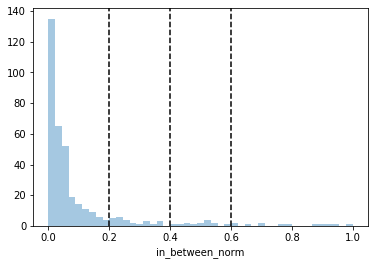

In [94]:
fig, ax = plt.subplots()
sns.distplot(long_res2["in_between_norm"], ax=ax, kde=False)#, bins=[i*0.05 for i in range(21)])
#ax.axvline(x=long_res2["in_between_norm"].mean(), ls="--", c="k")
#ax.axvline(x=long_res2["in_between_norm"].mean()+long_res2["in_between_norm"].std(), ls="--", c="k")
ax.axvline(x=0.6, ls="--", c="k")
ax.axvline(x=0.4, ls="--", c="k")
ax.axvline(x=0.2, ls="--", c="k")
#ax.set_xticks([i*0.1 for i in range(11)])

In [96]:
strong = long_res[long_res["category"]=="strong"]
mstrong = long_res[long_res["category"]=="medium strong"]
mweak = long_res[long_res["category"]=="medium weak"]

lines1 = list(zip(strong["origin"], strong["destination"]))
lines2 = list(zip(mstrong["origin"], mstrong["destination"]))
lines3 = list(zip(mweak["origin"], mweak["destination"]))
lines1

[('GALI BATU', 'JELEBU'),
 ('BENDEMEER', 'TAMPINES WEST'),
 ('BALESTIER', 'TYERSALL'),
 ('HONG KAH', 'JURONG WEST CENTRAL'),
 ('ANAK BUKIT', 'UPPER THOMSON'),
 ('CHOA CHU KANG CENTRAL', 'WESTERN WATER CATCHMENT'),
 ('SENGKANG TOWN CENTRE', 'PUNGGOL FIELD'),
 ('TAMPINES EAST', 'YISHUN WEST'),
 ('MATILDA', 'TAMPINES WEST'),
 ('JURONG WEST CENTRAL', 'HONG KAH'),
 ('JURONG WEST CENTRAL', 'JOO KOON'),
 ('WESTERN WATER CATCHMENT', 'CHOA CHU KANG CENTRAL')]

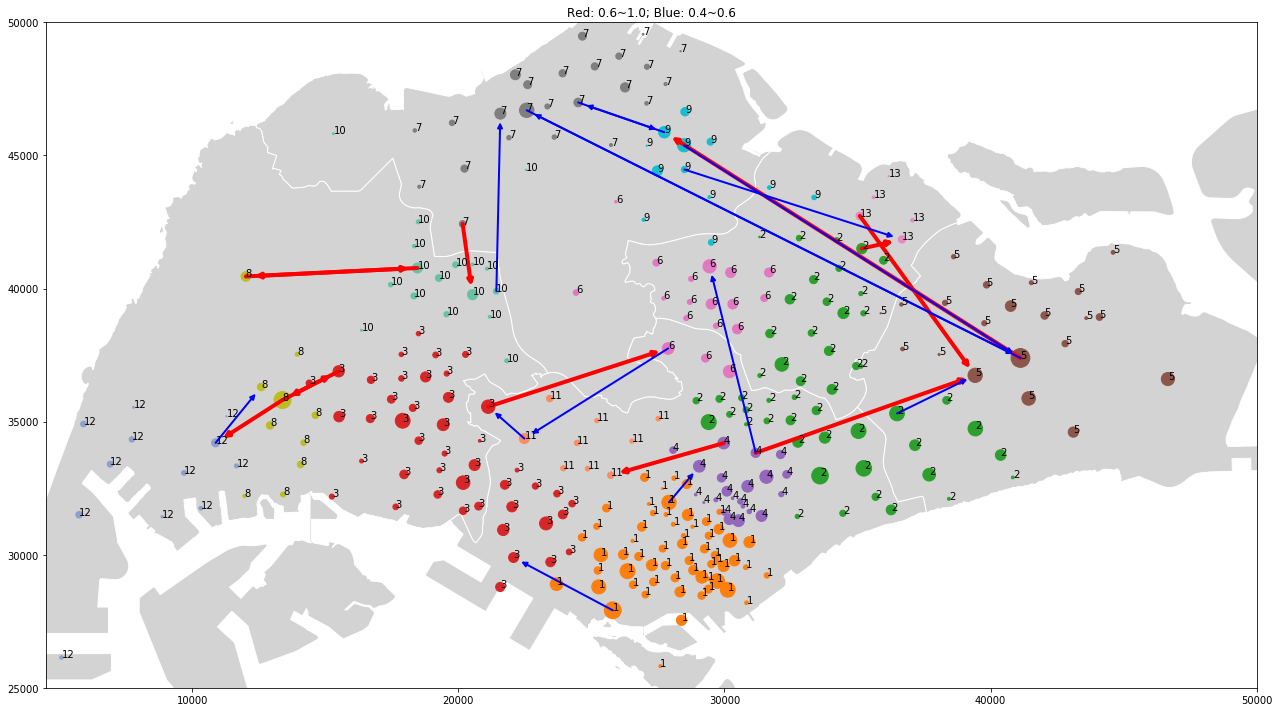

In [103]:
fig, ax = plt.subplots(figsize=(20,10))
region.plot(fc="lightgrey", ec="w", ax=ax)
ax.set_xlim([4500,50000])
ax.set_ylim([25000,50000])

#ax.scatter(nodes["lon"], nodes["lat"], s=nodes["flow"]*5000, c=[ color_map[g] if g in color_map else "k" for g in nodes["level_1_layer"] ])

ax.scatter(xs, ys, s=fs, color=cs)

for i, txt in enumerate(ws):
    ax.annotate(txt, (xs[i], ys[i]))
    
    
nx.draw_networkx_edges(dg1_08b, edgelist=lines1, pos=pos, width=4, edge_color="r")
nx.draw_networkx_edges(dg1_08b, edgelist=lines2, pos=pos, width=2, edge_color="b")
#nx.draw_networkx_edges(dg1b, edgelist=lines3, pos=pos, width=1, edge_color="k")
ax.set_title("Red: 0.6~1.0; Blue: 0.4~0.6")

plt.tight_layout()